In [1]:
import tensorflow as tf
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32


In [3]:
#데이터셋
DATASET_NAME = 'kfood'
DRIVE_PATH = Path(os.getcwd())
DATASET_PATH = DRIVE_PATH / DATASET_NAME
filepath = DATASET_PATH
print(filepath.exists())

True


In [4]:
def make_class_to_label_file():
    class_paths = list(glob(str(filepath) + '*/*/*'))
    class_names = [class_path.split('/')[-1] for class_path in class_paths]
    class_names = sorted(class_names)
    with open(DRIVE_PATH / 'class_to_label.txt', 'w', encoding='utf8') as f:
        for label, class_name in enumerate(class_names):
            f.write(str(label) + ',' + class_name + '\n')


In [5]:
#class_label 매칭 딕셔너리로 저장
LABELS = []
CLASSES = []
with open('class_to_label.txt','r', encoding='utf8') as f:
    for line in f.readlines():
        _label, _class = line.strip().split(',')
        LABELS.append(int(_label))
        CLASSES.append(_class)
#print(len(classes), len(labels), classes, labels)
#class_to_label = {}
#for _class, _label in zip(classes, labels):
#    class_to_label[_class] = int(_label)
LABELS = tuple(LABELS)
CLASSES = tuple(CLASSES)
if len(LABELS) == len(CLASSES):
    n_labels = len(LABELS)

In [6]:
def get_image_crop_points(filepath):
    crops = {}
    properties = filepath / "crop_area.properties"
    with open(properties, 'r') as p:
        for row in p:
            name, crop = row.replace("\n", "").replace(" ", "").split("=")
            if name != "" and crop != "":
                #name = name.encode('utf-8')
                crop = crop.split(",")
                if len(crop) >= 4:
                    crop = [int(crop[1]), int(crop[0]), int(crop[3]), int(crop[2])]
                    crops[name] = crop
                elif len(crop) == 2:
                    crop = [0, 0, int(crop[1]), int(crop[0])]
                    crops[name] = crop
            
    return crops

In [7]:
#crop 지점 정보 빼오기
crop_points = {}
class_list = list(filepath.glob("*/*"))
class_list = [class_name for class_name in class_list if class_name.is_dir()]
for class_name in class_list:
    crop_points.update(get_image_crop_points(class_name))

tf_crop_image_names = tf.constant(list(crop_points.keys()), dtype=tf.string)
tf_crop_points = tf.constant(list(crop_points.values()))


2022-01-24 14:34:20.738572: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-24 14:34:20.738694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [1]:

#데이터셋의 이미지 경로 및 레이블 저장
image_paths = sorted(glob("kfood/*/*/*"))
image_paths = [image_path for image_path in image_paths if image_path.split("/")[-1].split(".")[-1].lower() in ("png", "jpg", "jpeg")]
#labels = [class_to_label[Path(image_path).parent.stem] for image_path in image_paths]
n_images = tf.constant(len(image_paths), dtype=tf.int64)
print(n_images)#, len(labels))

In [9]:
#image_paths = sorted(glob("kfood/*/*/*"))
#image_formats = np.unique(np.array([image_path.split("/")[-1].split(".")[-1].lower() for image_path in image_paths]))
#print(image_formats)

In [10]:
def parse_and_crop_image(tf_filepath, label):
    
    image = tf.io.read_file(tf_filepath) # 이미지 파일 읽기
    filepath = tf.compat.path_to_str(tf_filepath)
    #format decoding
    image_format = tf.strings.lower(tf.strings.split(filepath, ".")[-1])

    if image_format == "jpeg":
        image = tf.image.decode_jpeg(image) # JPEG-encoded -> uint8 tensor (RGB format)
    elif image_format == "png":
        image = tf.image.decode_png(image, channels=3, dtype=tf.uint8)
    else:
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
    
    

    #crop
    image_name = tf.strings.split(tf.strings.split(filepath, "/")[-1], ".")[0]
    tf_image_idx = tf.where(tf_crop_image_names == image_name)
    
    #crop 정보가 있으면 크롭
    if tf.reduce_all(tf.not_equal(tf.shape(tf_image_idx), tf.constant((0, 1), dtype=tf.int32))):
        crop_offsets = tf_crop_points[tf.reshape(tf_image_idx, shape=())]
        image = tf.image.crop_to_bounding_box(image, crop_offsets[0], crop_offsets[1], crop_offsets[2], crop_offsets[3])

    return image, label

In [11]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 2
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 2
    right_crop = shape[1] - left_crop
    return image[top_crop : bottom_crop, left_crop : right_crop]


def resizing_image(image, label):
    image = central_crop(image)
    image = tf.image.resize(image, IMAGE_SIZE, method="nearest")
    image = tf.cast(image, tf.float32) / 255.
    return image , label

In [12]:
def make_kfood_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5, batch_size=32, cache=False):

    labels = [LABELS[CLASSES.index(filepath.split('/')[-2])] for filepath in filepaths]

    filenames_dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    labels = tf.one_hot(labels, n_labels, dtype=tf.uint8)
    
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    
    dataset = tf.data.Dataset.zip((filenames_dataset, labels_dataset))
    dataset = dataset.shuffle(n_images)

    dataset = dataset.map(parse_and_crop_image, num_parallel_calls=n_parse_threads)
    dataset = dataset.map(resizing_image, num_parallel_calls=n_parse_threads)
    #dataset = filenames_dataset.map(spa)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    if batch_size:
        dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [13]:
#데이터셋 생성
dataset = make_kfood_dataset(image_paths, shuffle_buffer_size=5000, n_parse_threads=tf.data.AUTOTUNE, batch_size=BATCH_SIZE)

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2022-01-24 14:41:19.233170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-24 14:41:20.372618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-01-24 14:41:20.470230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


tf.Tensor([[134]], shape=(1, 1), dtype=int64)
tf.Tensor([[125]], shape=(1, 1), dtype=int64)
tf.Tensor([[123]], shape=(1, 1), dtype=int64)
tf.Tensor([[58]], shape=(1, 1), dtype=int64)


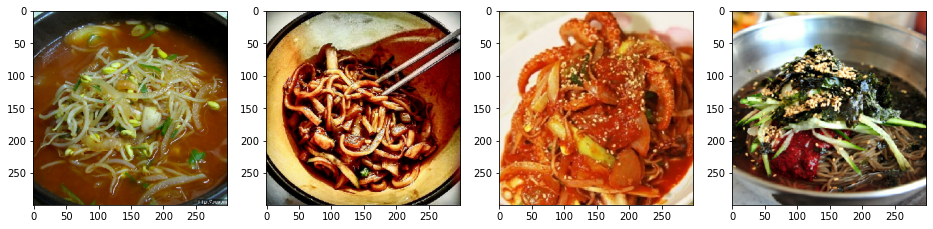

In [20]:
def dataset_image_plot_4():
    for images, labels in dataset.take(1):
        plt.figure(figsize=(16,8))
        plt.axis("off")
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(images[i])
            print(tf.where(labels[i] == 1))

            
dataset_image_plot_4()